# Report
*info hier* aa

## Packages
Packages required to run the code in this notebook.

In [51]:
# modules
!pip install oddt
!pip install vina
!pip install biopandas
import sys, os, shutil
import nglview
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage
import numpy as np
import pandas as pd
import requests
import math
from math import isnan, isinf
import seaborn as sns

from pathlib import Path
from warnings import filterwarnings
import time

from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import py3Dmol
import glob
from vina import Vina
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
import pubchempy as pcp
from urllib.parse import quote

from IPython.display import Markdown, Image


import io
import gzip
from biopandas.pdb import PandasPdb



import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

# local scripts
from scripts import viewer
from scripts import bio_align
from utils import seed_everything



Set the working directory to the Report_data folder.



In [52]:
HOMEDIR = str(Path.home())+"/Report"
HOMEDIR
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Report_data')
except:
    print("Directory already exists")
os.chdir('Report_data')

SEED = 1
seed_everything(SEED)
os.getcwd()

Directory already exists


'/home/jovyan/Report/Report_data'

# Assignments:
The goal of this course is to design a new ligand for the target that was assigned to you. You will work in pairs. This ligand should dock with a higher docking score than the co-crystalized ligand. You will reach this goal by executing a bio-informatics part, a chem-informatics part, and finally perform docking.

Measurement Report:
The results from your practical work are to be written down in a measurement report, which is to be handed in on Monday. This report should contain answers to the questions from the manual, and descriptions of what you did during the course (your train of thought). Naturally you should also include name, student number, etc. 

Presentation:
In addition, you are to hold a presentation on these subjects on Friday the 7th of October (afternoon). The presentation should last ~10 minutes with some subsequent discussion. In the presentation you should provide a background of your drug target and drug (type, pathology etc). There should be some results from the QSAR modeling and several docked poses. You should present your newly designed drug and defend why it is better. 

The practical consists of three parts, which each have their own Jupyter notebook with instructions and the code to run:

- Intro to cheminformatics
- Machine learning and QSAR
- Working with crystal structures



# Bioinformatics

### Analyzing your Drug target

It is important to get a good feeling for the target you are about to study. This is where literature research comes into play. A good starting point is the original publication that your PDB code refers to. This will also give you further references. In addition, general reviews (Pubmed, Google Scholar) can be very helpful.

1.	Describe the target (your report should contain at least the following information):
-	Pathology (why are we interested in the target?)
-	Clinical drugs available (which drugs are on the market)
 	Also use ATC information to further describe the drugs. 
-	Protein information (what family of proteins is the target a member off, where is it located in the body?)

### Related proteins (off-targets), based on sequence

Using Bio-informatics we are going to compare the target to other proteins. We use the primary structure (sequence) of the protein for this. Go to: http://www.uniprot.org/

    
Questions (1):
-	Which target is more similar compared to the original target?
-	Did you expect this?

Align the 3 proteins on Uniprot using the ‘Accession’ numbers. 

In the overview, select the following tickboxes: “Similarity, Hydrophobic, Negative, Positive, Aromatic”, scroll down and make a screenshot (for report and presentation). Which targets are ‘more similar’ ?

### Related proteins (off-targets), based on structure

Since we are in the fortunate position that we have a crystal structure, we are also going to use a 3D similarity search. This is a structural similarity search rather than a sequence similarity search. Now we compare proteins based on their tertiary structure (3D structure)

10.	Start at http://www.rcsb.org/pdb/home/home.do  and find your target using the PDB identifier. 
11.	Scroll down to ‘macromolecules’.
12.	Click ‘structure’

![image info](Report_data/Images/LAB00_FIG00.png)

13.	The top one should be your protein.
•	Write down the accession of the next most similar one 
•	In the case of a GPCR target, ignore the T4Lysozyme hits
14.	Go to: https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html use align and select structure to structure.

![image info](Report_data/Images/LAB00_FIG01.png)

15.	Input both pdb codes and click all matching molecules superposed.

16.	After completion do file  realign and select ‘on sequence alignment’ 

17.	Select the ‘A’ chains and click realign. Note the RMSD below (realignment RMSD). 

![image info](Report_data/Images/LAB00_FIG02.png)

18.	Make a screenshot of the superposition. 

In [53]:
#Dataframe of the target, the target in a different species, and the protein closest to the target that is not an isoform.

proteins = pd.DataFrame({"Protein name":["Non-receptor tyrosine-protein kinase","Tyrosine-protein kinase","Tyrosine-protein kinase"],
              "Protein family":["JAK","JAK","JAK"],
              "Gene":["TYK2","TYK2","JAK1"],
              "Species":["Homo sapiens (Human)","Pan troglodytes (Chimpanzee)","Homo sapiens (Human)"],
              "Accession number":["P29597","K7AU67","P23458"],
              "Amino acid length":[1187,1187,1154],
              "Mass (Da)":[133650,133769,133277],
              "Protein existence":["Evidence at protein level","Evidence at transcript level","Evidence at protein level"],
              "Status":["UniProtKB reviewed (Swiss-Prot)","UniProtKB unreviewed (TrEMBL)","UniProtKB reviewed (Swiss-Prot)"]})

display(proteins)

,Protein name,Protein family,Gene,Species,Accession number,Amino acid length,Mass (Da),Protein existence,Status
0,Non-receptor tyrosine-protein kinase,JAK,TYK2,Homo sapiens (Human),P29597,1187,133650,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)
1,Tyrosine-protein kinase,JAK,TYK2,Pan troglodytes (Chimpanzee),K7AU67,1187,133769,Evidence at transcript level,UniProtKB unreviewed (TrEMBL)
2,Tyrosine-protein kinase,JAK,JAK1,Homo sapiens (Human),P23458,1154,133277,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)


# Retrieving a 3D structure

Next, we will prepare our protein. The first step is to download it from the .pdb. We will the ngl viewer for this. 


We will add hydrogen atoms to the structure, because these are normally not resolved in the structure (due to limitations in resolution of the experimental method.



This part of the code shows the target protein TYK2 with the ligand 0X5 in a 3D viewer together with the residues within 5 Angstrom of the ligand.

In [54]:
TARGET_PDB_ID = "4gih" #TYK2 P29597
LIGAND_CODE = "0X5" #Residue name of ligand in TYK2 P29597

view_target = nglview.show_pdbid(TARGET_PDB_ID)
view_target


viewer.show_residues_around(view_target)
view_target.center(LIGAND_CODE)
view_target

NGLWidget()

Have a look at the residues near the ligand, can you observe any important interactions? Describe in your report which interactions you observe, and what type of interactions they are.

Note that we do not see any hydrogen atoms, do you know why?

-Hydrogens are below the resolution of the x-ray method

In the next stage, we will add the hydrogens and have another look at the structure. We will split the protein and ligand and save them seperately. For this, we use biopython. https://biopython.org/docs/1.75/api/Bio.html

In [55]:

#########################################################
#Adding hydrogens to docking site residues of the target#
#########################################################

#Retrieve coordinates of target and turn it into a BioPython object
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))


#Save the ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())


#Load ligand
command = 'bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    

#view the target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_target_residues_hydrogens = nglview.show_file(f, ext="pdb")
    
view_target_residues_hydrogens.center(LIGAND_CODE)
viewer.show_residues_around(view_target_residues_hydrogens)
view_target_residues_hydrogens


#Have a look at the residues near the ligand, can you observe any important interactions? Describe in your report which interactions you observe, and what type of interactions they are.

#Note that we do not see any hydrogen atoms, do you know why?

#-Hydrogens are below the resolution of the x-ray method

Structure exists: '4gih/4gih.cif' 


NGLWidget()

Let's have a look again at the protein

You can move around the structure with the mouse. Scrolling will zoom in/out, with the left mouse button you can rotate the structure. If you click the scrolling wheel you can move around the structure (sliding).

23. Now, we will repeat the procedure for the most similar target that you identified (the highest scoring hit from the PDB):

In [56]:
#############################################################
#Adding hydrogens to docking site residues of the off_target#
#############################################################

OFF_TARGET_PDB_ID = "7q7l" # Enter your off target PDB code here, example = '5uen'
OFF_TARGET_LIGAND = "9I2"  # Enter the ligand code here, example = 'DU1'

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))


#Save ligand
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())



#Load ligand
command = 'bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))



#Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
                    
#View the off_target and ligand in 3D with nglviewer
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view_offtarget = nglview.show_file(f, ext="pdb")
    
view_offtarget.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view_offtarget)
view_offtarget

Structure exists: '7q7l/7q7l.cif' 


NGLWidget()

25. Now, let's try to align the structures. First we generate the alignment object

In [57]:
###########################################
#Aligning target 4GIH and off-target in 3D#
###########################################

# Get the structures
PDBCODE_1 = '4gih' # Name of the first structure
PDBCODE_2 = '7q7l' # Name of the second structure


data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

bio_align.run('{}-complex.pdb'.format(TARGET_PDB_ID),'{}-complex.pdb'.format(OFF_TARGET_PDB_ID))


# combine protein and ligand files
filenames = [
'{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view_alignment = nglview.show_file(f, ext="pdb")
    
view_alignment

Alignment(seqA='M--------------------GSPAS-DPTV-FHK--RY-LKKIRD-L---GE-GH-FGKVSLY---C-YDPTN--DG-TGEMV-AVKALKADAGP-QHRSGWKQ-EI----D----I--LRT--LYHE-HI--I-KYKGC-CED--AGAAS---LQ-LV-MEYVPL--GSLRDYLP-----R--HSIGLAQL-LLFAQ---QICE-GMA-YLHAQH----YIHRN-LAA-RNVL-LD--ND--RLVKIGDFGLA-KAV-PEGH---EYYR-VR-ED-GD-SPV-FWYAPEC-LK-EY-KFYY--ASDVWSFGVT-LYELL-THCDS----SQ-SPPTKFL-EL----IGIA---QGQMT--VLRLT---ELLER---GERLPRPDK-CPA-EV-YHLMKNCWE--TEASF--------RPT-FEN--LIPI-LKT-VHEKY---RHHHHHH-----', seqB='MHHHHHHDYKDDDDKENLYFQG----RDPT-QF--EER-HL-K---FLQQLG-KG-NFG--S--VEMCRYDP--LQD-NTGE-VVAVK--K-----LQH-S----TE-EHLRDFEREIEIL--KSL---QH-DNIVKYKG-VC--YSAG---RRNL-KL-IMEY--LPYGSLRDYL-QKHKERIDH-I-----KLL--QYTSQIC-KGM-EYL----GTKRYIHR-DL-ATRN--IL-VEN-ENR-VKIGDFGL-TK-VLP---QDKEYY-KV-KE-PG-ESP-IFWYAPE-SL-TE-SKF--SVASDVWSFGV-VLYE-LFT----YIEKS-KSPP----AE-FMRMIG--NDKQGQ--SIV---THLIELL--KNNG-RLPRPD-GCP-DE-IY--M-----IMTE---CWNNNVNQRP-SF--RDL---AL--RV----DQIR------DNMAG', score=161.0, start=0, end=457)


NGLWidget()

In [58]:
print("This is the target protein TYK2")
display(view_target_residues_hydrogens)

print("This is the target protein JAK1")
display(view_offtarget)

print("This is the alignment of TYK2 and JAK1")
display(view_alignment)

This is the target protein TYK2


NGLWidget()

This is the target protein JAK1


NGLWidget()

This is the alignment of TYK2 and JAK1


NGLWidget()

Are the structures nicely aligned?

You can also align structure using https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html as you've seen previously.

You can also have a look at PLIP, which is a nice interaction profiler as well:
https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index

Finally, the interaction viewer on rcsb itself is also quite good, just type in your accession code in the search bar, scroll down to the ligand overview and click the ligand interaction box.

Toy around a bit with the structures and see if you can get a feeling for the binding site. In particular what kind of interactions seem to be important. Feel free to discuss this with your supervisor as well!

Another great way to look at the structure is on the rcsb website itself, where you can go to a 3D viewer of the ligand binding site by clicking on the Ligand interaction button. 



This is the end of the bioinformatics part of the lab, for the report, please add a screenshot of the PLIP viewer. Try to identify key interactions in the binding site, either on the RCSB website or PLIP. Also think already how you might improve the ligand, can you think of additional interactions? The next two days, we will try to optimize the ligand. Tomorrow we will work with QSAR and cheminformatics. The day after we will use docking

In [59]:
display(proteins)

,Protein name,Protein family,Gene,Species,Accession number,Amino acid length,Mass (Da),Protein existence,Status
0,Non-receptor tyrosine-protein kinase,JAK,TYK2,Homo sapiens (Human),P29597,1187,133650,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)
1,Tyrosine-protein kinase,JAK,TYK2,Pan troglodytes (Chimpanzee),K7AU67,1187,133769,Evidence at transcript level,UniProtKB unreviewed (TrEMBL)
2,Tyrosine-protein kinase,JAK,JAK1,Homo sapiens (Human),P23458,1154,133277,Evidence at protein level,UniProtKB reviewed (Swiss-Prot)


Protein sequence aligment of the proteins shown above:
![image info](Report_data/Images/Sequence_alignment.jpeg)

# start machine learning
In this section, we will look into cheminformatics. We ended the last session looking at the interaction of the ligand in the binding site. To refresh our minds, 

1. lets have another look at the protein-ligand interactions with PLIP:

 https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index
 
 What also is informative is to do a short literature study.

2. Find the Structure – Activity – Relationship (SAR) for your ligand. Use medicinal chemistry journals, like (but not limited to) J. Med. Chem., Bioorg Med Chem (Lett), ChemMedChem

PLIP protein ligand interation profile
![image info](Report_data/Images/4GIH_0X5_A_1201.png)
![image info](Report_data/Images/4GIH_0X5_A_1201_3D.png)
![image_info](Report_data/Images/PLIP_table.png)


For this next part, we need to have the SMILES (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representation of the molecule. You can retrieve this by going to the pdb, and fetch the InChI key for the ligand in your structure (use the RCSB accession code).

4. The image below shows the InChI key for zma241385 in blue:
![image info](Report_data/Images/LAB01_FIG00.png)

5. Using the InChI key, you can retrieve the SMILES from PubChem ((http://pubchem.ncbi.nlm.nih.gov/). Use the search bar where you paste the InChI key in, then run the search, you should retrieve the compound. Click on the entry, and you can find them under 2.1.4 Canonical Smiles. Write down the SMILES that you retrieved from PUBCHEM

InChiKey: IAFNAEGXTKTGHN-UHFFFAOYSA-N
Smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl  

6.	Find similar compounds by going to the Similarity tab, how many compounds were retrieved? Under settings, you can adjust the tanimoto threshold, change it to 80%, how much are retrieved now?

90% 430 results
80% 1000 results

7.	Go to https://www.ebi.ac.uk/chembl/, again use the InChI key from the previous step, click the entry. Write down the CHEMBLID. Next, do a Structure Search (button under the compound drawing).

ChEMBL ID: CHEMBL2387224

8.	Fetch 95% similar compounds, how much compounds were retrieved? Do the same but with 90%. Do you have more or less compounds than in step 6? Do you know why?

95% 1 compound
90% 1 compound


9.	Use the Zinc site to search for possible similar ligands at http://zinc15.docking.org/substances/home/ .Again use the copied smiles string do a 70 % similar search (Tanimoto 70, written as similarity -30). Write down the number of hits and copy 1 representative molecule from each search. Discuss the results, how high is the impact of the similarity threshold?

-30 = 20 similar compounds
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-30=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl

https://zinc15.docking.org/substances/ZINC000096928695/

-40 = 17 compounds
https://zinc15.docking.org/substances/?highlight=C1CC1C%28%3DO%29NC2%3DNC%3DCC%28%3DC2%29NC%28%3DO%29C3%3DC%28C%3DCC%3DC3Cl%29Cl&ecfp4_fp-tanimoto-40=O%3DC%28Nc2ccnc%28NC%28%3DO%29C1CC1%29c2%29c3c%28Cl%29cccc3Cl



Obtaining and cleaning data.

Let's now start with some data. You should have a CHEMBLID in your list, here we use CHEMBL251 (Adenosine A2a) as an example.

10. We're going to download a dataset downloaded from ChEMBL, and read it into pandas, you can download the files from ChEMBL directly and upload them to the notebook environment (https://www.ebi.ac.uk/chembl/). Be sure to upload the extracted file (not the .zip file) and to give it a clear name so you can write it down in the below code block. 


Ask a TA if anything is unclear!

In [60]:
CHEMBLID = 'CHEMBL3553' # Enter the CHEMBL ID of your target here
FILENAME = 'CHEMBL3553.csv' # The filename of the uploaded file

data = pd.read_csv(FILENAME, sep = ";")
data= data[data['Standard Type'] == "IC50"]
print("There are a total of {} datapoints in this set".format(len(data)))


type(data)

There are a total of 1920 datapoints in this set


pandas.core.frame.DataFrame

In [61]:
display(data.head())

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
4,CHEMBL2181327,NaN,0,459.59,0,4.49,"17h, 85:15 trans/cis mixture",CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc(n1)N2,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL2176955,1,Scientific Literature,J. Med. Chem.,2011.0,None,NaN
5,CHEMBL2181315,NaN,0,359.43,0,4.99,"16a, 85:15 trans/cis mixture",C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL2176955,1,Scientific Literature,J. Med. Chem.,2011.0,None,NaN
25,CHEMBL21156,NaN,0,309.34,0,3.99,6,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1135866,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,None,NaN
38,CHEMBL1938656,NaN,0,462.60,0,3.00,22,COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C)C)cc3)sc12,IC50,'>',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1938231,1,Scientific Literature,J. Med. Chem.,2011.0,CHEMBL3307634,NaN
48,CHEMBL1938648,NaN,0,382.49,0,3.08,13,CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12,IC50,'=',...,Tyrosine-protein kinase TYK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1938231,1,Scientific Literature,J. Med. Chem.,2011.0,CHEMBL3308860,NaN


In [62]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']]
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data = pd_data.reset_index(drop=True)
display(pd_data.head())
print("There are a total of {} datapoints in this set".format(len(pd_data)))

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc(n1)N2,B,'=',71.0
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0
3,CHEMBL1938656,NaN,COCCNC(=O)c1cnc(N)c2cc(-c3ccc(S(=O)(=O)NC(C)(C)C)cc3)sc12,B,'>',25000.0
4,CHEMBL1938648,5.29,CN(C)C(=O)c1cnc(N)c2cc(-c3ccc(N4CCOCC4)cc3)sc12,B,'=',5150.0


There are a total of 1920 datapoints in this set


You will note that we have a lot of data, and we certainly don't need it all, thus we're going to remove quite some columns.

11. Actually, for now we only need the compound ID, pCHEMBL_value, Assay Type, binding affinity and the smiles:

Next, we will add an activity classifier, there is a lot of censored data in the set and these typically are compounds that only bind weakly! We still want to know about those non-binders though.

Let's set our activity threshold at PChEMBL > 6.5 for the actives, if you want to know more details have a look at this paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0232-0

12. Here we go!

In [63]:
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 914
Number of inactive compounds: 1006


Finally, we will drop functional assay readout, this is data that we don't want to consider in our model.

In [64]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 1880 activity points left


#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we incorporated the choice between the following fingerprints:

* maccs
* morgan2 and morgan3

In [65]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [66]:
compound_df = pd_data.copy()

In [67]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc(n1)N2,B,'=',71.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

Additionally, we will comment on the results.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function `model_training_and_validation` which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set. We also plot the ROC curves using `plot_roc_curves_for_models`.

We then define a function named `crossvalidation` which executes a cross validation procedure and prints the statistics of the results over the folds.

#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [68]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [69]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [70]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [71]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1504
Test data size: 376


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [72]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [73]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.77
Specificity: 0.74
AUC: 0.83


Directory already exists, continuing


'/home/jovyan/Report/Report_data/results/roc_auc.png'

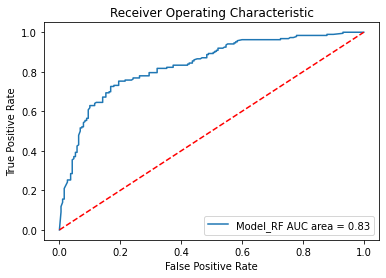

In [74]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [75]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.79
Specificity: 0.77
AUC: 0.84


'/home/jovyan/Report/Report_data/results/roc_auc.png'

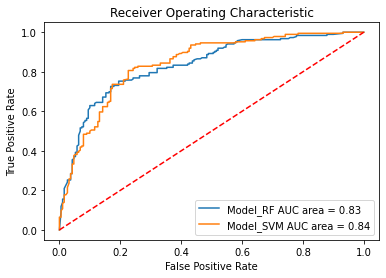

In [76]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [77]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.76
Specificity: 0.69
AUC: 0.81


'/home/jovyan/Report/Report_data/results/roc_auc.png'

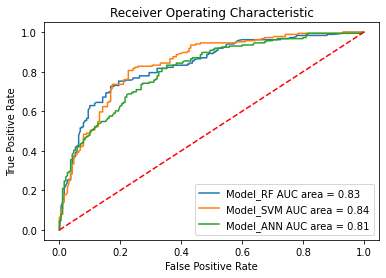

In [78]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [79]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [80]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [81]:
#for model in models:
#    print("\n======= ")
#    print(f"{model['label']}")
#    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)

We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [82]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [83]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL2181327,7.15,CN(C)CCN(C)c1ccc2cc1COCC=CCOCc1cccc(c1)-c1ccnc(n1)N2,B,'=',71.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2181315,5.28,C1=CCCOc2cccc(c2)-c2ccnc(n2)Nc2cccc(c2)OCC1,B,'=',5200.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL21156,9.00,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,B,'=',1.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


_Note_: Next cell takes long to execute

In [84]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.79 	and std : 0.01 
Mean sensitivity: 0.79 	and std : 0.01 
Mean specificity: 0.79 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 4.69s


Model_ANN
Mean accuracy: 0.76 	and std : 0.01 
Mean sensitivity: 0.76 	and std : 0.04 
Mean specificity: 0.76 	and std : 0.03 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 37.27s



So far, we have been running classification models (is the compound going to be active or not, indicated by the active column we added in the dataframe). The next step is to see if we can also train a regression model. We will remove the censored data (the ones with no pChEMBL value), and train another model. 

Make a new function that works with regression:

In [85]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, make new data and run.

In [86]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1504
Test data size: 376


In [87]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=3)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 0.56 	and std : 0.01 
RMSE: 0.77 	and std : 0.01 



In [88]:
#example of neural network regressor

#regressor = MLPRegressor(hidden_layer_sizes=(1000,),max_iter=1000)
#MAEx, RMSEx,trained_modelx = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=3)

#print(
#f"MAE: {np.mean(MAE):.2f} \t"
#f"and std : {np.std(MAE):.2f} \n"
#f"RMSE: {np.mean(RMSE):.2f} \t"
#f"and std : {np.std(RMSE):.2f} \n"
#)

You will notice that we report different measures of accuracy. We no longer deal with categorical data so we now look at the errors between experimental data and predicted data using the MAE and RMSE. Typically, an MAE/RMSE below 0.6, approximately, is considered quite decent/

Next, let's use the RF model to run predictions on a new compound. You can design your compounds in a sketcher (chemdraw (https://chemdrawdirect.perkinelmer.cloud/js/sample/index.html#) or an online tool).

In [89]:


#pubchem query functions

def query_pubchem_for_similar_compounds(smiles, threshold=80, n_records=10, logp=5, MW=1000):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}&fullsearch=true&mw_lte={MW}&xlogp_lte={logp}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key


def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

To obtain a dataset of ligands to screen with the regression model, a few important ligands were queried on pubchem with a similarity search of 80% and the results were filtered for a XLogP <= 5 and a Exact Mass <= 1000. Ligands that were queried for similarity are 0X5 (reference), the ligand with the highest affinity for TYK2 on ChEMBL, deucravatinib (a TYK2 inhibitor the market), and JAK inhibitors tofacitinib, abrocitinib, baricitinib, upadacitinib, and filgotinib. (https://www.ema.europa.eu/en/medicines/human/referrals/janus-kinase-inhibitors-jaki)
**Running this code may take a while.**



In [90]:
#query_df = pd.DataFrame({
#    "ligand ID":["Reference_0X5",
#                         "ChEMBL_TYK2",
#                         "Deucravacitinib",
#                         "Tofacitinib",
#                         "Abrocitinib",
#                         "Baricitinib",
#                         "Upadacitinib",
#                         "Filgotinib"
#                         ],
#     "SMILES":['C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl', #0X5, PDB reference ligand
#             '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC', #Best ChEMBL TYK2 ligand
#             '[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC', #Deucravacitinib, TYK2
#             'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N', #Tofacitinib, JAK
#             'CCCS(=O)(=O)NC1CC(C1)N(C)C2=NC=NC3=C2C=CN3', #Abrocitinib, JAK
#             'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3', #Baricitinib, JAK
#             'CCC1CN(CC1C2=CN=C3N2C4=C(NC=C4)N=C3)C(=O)NCC(F)(F)F', #Upadacitinib, JAK
#             'C1CC1C(=O)NC2=NN3C(=N2)C=CC=C3C4=CC=C(C=C4)CN5CCS(=O)(=O)CC5' #Filgotinib, JAK
#            ]})


query_df = pd.DataFrame({
    "ligand ID":["Reference_0X5",
                         "CHEMBL4789639",
                         "CHEMBL4793760",
                         "Deucravacitinib",
                         "Ruxolitinib",
                         "AT-9283",
                         "Peficitinib",
                         "Tofacitinib",
                         "Baricitinib"
                         ],
     "SMILES":['C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl', #0X5, PDB reference ligand
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC', #CHEMBL4789639
            #  'Cn1cc(-c2ccc(Nc3nn([C@H]4COCC[C@@H]4C#N)cc3C(N)=O)cc2)cn1', #CHEMBL4078799 this one messes up docking, don't know why
               '[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC', #CHEMBL4793760
               '[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC', #Deucravacitinib, TYK2
           #   'CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4', #Staurosporine, TYK2 staurosporine has a high docking score but visually it does not look good
               'N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1', #Ruxolitinib, TYK2
               'O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1', #AT-9283, TYK2
               'NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2', #Peficitinib, TYK2
               'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N', #Tofacitinib, JAK
               'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1' #Baricitinib
            ]})



querylist = query_df['SMILES'].tolist()

screening = []
for query in querylist:
    print("\n\n\nCurrently querying smiles: {}.\n".format(query))
    job_key = query_pubchem_for_similar_compounds(query, threshold=90, n_records=10000)
    similar_cids = check_and_download(job_key)
    #similar_smiles = smiles_from_pubchem_cids(similar_cids)
    a= pcp.get_properties(['canonical_smiles', 'XLogP', 'ExactMass'],
                                similar_cids)
    a= pd.DataFrame.from_records(a).dropna()
    a['ExactMass'] = a['ExactMass'].astype(float)
    a[(a['XLogP'] <= 5) & (a['ExactMass'] <= 1000)]
    a=list(a['CanonicalSMILES'])
    screening.extend(a)
    print("\nThis query resulted in {} results,\nwhich makes the current amount of compounds in the screening dataset {}.".format(len(a),len(screening)))
    #query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
    #screening = screening.append(query_results_df)
    
#PandasTools.AddMoleculeColumnToFrame(screening, smilesCol="smiles")

print("\nThe amount of compounds currently in the screening dataset is: {}.".format(len(screening)))

print("\nA few examples are: \n{}, \n{},\n{}.".format(screening[1],screening[2],screening[3]))






Currently querying smiles: C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl.

Querying for job 805129499579786904 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/805129499579786904/cids/JSON....
This query resulted in 415 results,
which makes the current amount of compounds in the screening dataset 415.



Currently querying smiles: [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC.

Querying for job 208951053295074709 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/208951053295074709/cids/JSON....
This query resulted in 183 results,
which makes the current amount of compounds in the screening dataset 598.



Currently querying smiles: [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC.

Querying for job 217449798583223906 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/217449798583223906/cids/JSON....
This query resulted in 183 results,
which makes the current amount of compounds in the scre

#### Adding the queried compounds to the dataset and generating the fingerprints.

In [91]:
#screening = pd.read_csv("SCREENINGDATA.csv", sep = ",")
#screening_data = screening['isosmiles']
test_smiles = screening.copy()
test_smiles = querylist+test_smiles  #this makes sure the queried compounds are being predicted as well, some but not all of them are already in this list, but duplicates are dropped anyways.
fps = []
drop = []

for smiles in test_smiles: 
    try:
        fp = smiles_to_fp(smiles,'morgan3')
        fps.append(fp)
    except:
        drop.append(smiles)
        
for i in drop:
    test_smiles.remove(i)


#### Making bioactivity predictions on the screening dataset and select the five highest scoring compounds in addition to the queried compounds.

In [92]:
screened_df = pd.DataFrame()
pd.options.display.max_colwidth = 200
screened_df["smiles"] = test_smiles
predictions = trained_model.predict(fps)
#print("SMILES, PREDICTION")
#for i, prediction in enumerate(predictions):
#    print('{},{:.2f}'.format(test_smiles[i], prediction))
#set number of highest predicted compounds you'd like in the dataset    
topslice=10

screened_df["prediction"] = predictions
screened_df["prediction_type"] = "regression"
screened_df = screened_df.drop_duplicates(subset = 'smiles')
print("Excluding duplicates, a total of {} pChEMBL values have been predicted".format(len(screened_df)))
screened_df_full = screened_df.copy()

screened_df = screened_df.sort_values(by="prediction", ascending = False)[:topslice]
file = "SCREENEDDATA.csv"
screened_df.to_csv(file)


screened_data = screened_df.copy() #Alternatively use: pd.read_csv("SCREENEDDATA.csv")
display(screened_data)

#The first 8 indices are the queried compound, this code checks for duplicates in the top 5 predicted compounds and replaces them with the next highest predicted smiles
#nr of top predicted values to replace duplicate with
appendindex = topslice+1
while sum(screened_data.index<=(len(querylist)-1))>0:
    Index = screened_data.index[screened_data.index<(len(querylist)-1)][0] #index of the duplicate
    print(f"One of the top {len(screened_data)} predicted values ({query_df.iloc[Index][1]}) is one of the queried compounds: {query_df.iloc[Index][0]}, replacing it with the nr {appendindex} of the regression predicted smiles")
    screened_data = screened_data.drop(Index)
    screened_data = screened_data.append(screened_df_full.sort_values(by="prediction", ascending = False)[appendindex-1:appendindex]) #drop duplicate and append next highest predicted element
    appendindex += 1

#Creates list of ligand id's for the predicted values based, supports any number of predicted values
predicted_nr = []
for i in range(sum(screened_data.index>(len(querylist)-1))):
    predicted_nr.append("Predicted_nr"+str(i+1))

#adds queried ligands to dataframe
screened_data = screened_df_full[screened_df_full['smiles'].isin(querylist)].append(screened_data).drop_duplicates(subset = 'smiles')
identifiers = pd.DataFrame({"ligand ID": query_df['ligand ID'].append(pd.Series(predicted_nr)).reset_index(drop=True)})
screened_data["ligand ID"] = identifiers.values #names ligands
display(screened_data)
docking_smiles = screened_data['smiles']
print(docking_smiles)

Excluding duplicates, a total of 4033 pChEMBL values have been predicted


,smiles,prediction,prediction_type
3,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC,8.726369,regression
3414,C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O,8.313694,regression
6,NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2,8.313694,regression
2,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC,8.293467,regression
3601,C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)N,8.205439,regression
5,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1,8.187450,regression
3593,C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)N,8.173945,regression
3420,C1C2CC3CC(C2NC4=C5C=CNC5=NC=C4C(=O)N)CC1C3O,8.162873,regression
3435,CC12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N,8.162305,regression
3599,CN(C)C(=O)C12CC3CC(C1)C(C(C3)C2)NC4=C5C=CNC5=NC=C4C(=O)N,8.156339,regression


One of the top 10 predicted values ([2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC) is one of the queried compounds: Deucravacitinib, replacing it with the nr 11 of the regression predicted smiles
One of the top 10 predicted values (NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2) is one of the queried compounds: Peficitinib, replacing it with the nr 12 of the regression predicted smiles
One of the top 10 predicted values ([2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC) is one of the queried compounds: CHEMBL4793760, replacing it with the nr 13 of the regression predicted smiles
One of the top 10 predicted values (O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1) is one of the queried compounds: AT-9283, replacing it with the nr 14 of the regression predicted smiles


,smiles,prediction,prediction_type,ligand ID
0,C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl,6.912572,regression,Reference_0X5
1,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC,7.973507,regression,CHEMBL4789639
2,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC,8.293467,regression,CHEMBL4793760
3,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC,8.726369,regression,Deucravacitinib
4,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,7.912867,regression,Ruxolitinib
5,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1,8.187450,regression,AT-9283
6,NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2,8.313694,regression,Peficitinib
7,CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N,7.278822,regression,Tofacitinib
8,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1,7.393061,regression,Baricitinib
3414,C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O,8.313694,regression,Predicted_nr1


0                             C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl
1       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC
2       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC
3        [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC
4                                N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
5                          O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1
6                NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2
7                                   CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N
8                         CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1
3414                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O
3601                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)N
3593                       C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)N
3420                              C1C2CC3CC(C2NC4=C5C=CNC5=NC=C4

## Discussion

* Which model performed best on our data set and why?
    * All three models perform (very) well on our dataset. The best models are the random forest and support vector machine models which showed a mean AUC of about 90%. Our neural network showed slightly lower results. 
    * There might be several reasons that random forest and support vector machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions or with the radial basis function, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN could be that there was simply too few data to train the model on.
    * Additionally, it is always advisable to have another external validation set for model evaluation.  
* Was MACCS the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible. 
    * However, MACCS keys are rather short (166 bit) compared to others (2048 bit), as for example Morgan fingerprint. As shown in the last simulation, having longer fingerprint helps the learning process. All tested models performed slightly better using Morgan fingerprints (see mean AUC increase).

    
### Where can we go from here?

* We successfully trained several models. 
* The next step could be to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For such an application, see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.

## Quiz

* How can you apply ML for virtual screening?
* Which machine learning algorithms do you know?
* What are necessary prerequisites to successfully apply ML?

# Molecular docking

In this lab, we will perform molecular docking on the SMILES strings you generated in the Machine Learning lab. We will also use the prepared protein from the first lab.

## Content of this notebook

1. Feching system and cleanup
2. System Visualization 
3. Docking with AutoDock Vina
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - 3D visualization of docking results

## 1. Fetching system and cleanup

Next, we will copy back the prepared protein from the previous lab in this folder. Note that we will only work with the on-target here, so we only need to copy that:

Next we will generate the 3D coordinate files of each of the ligands. You can copy the smiles directly from the last box in the Machine Learning notebook:

The 3D files will be generated using rdkit.

The first 9 ligands are from the querylist. The last 10 are the top 10 predicted ligands in descending order.


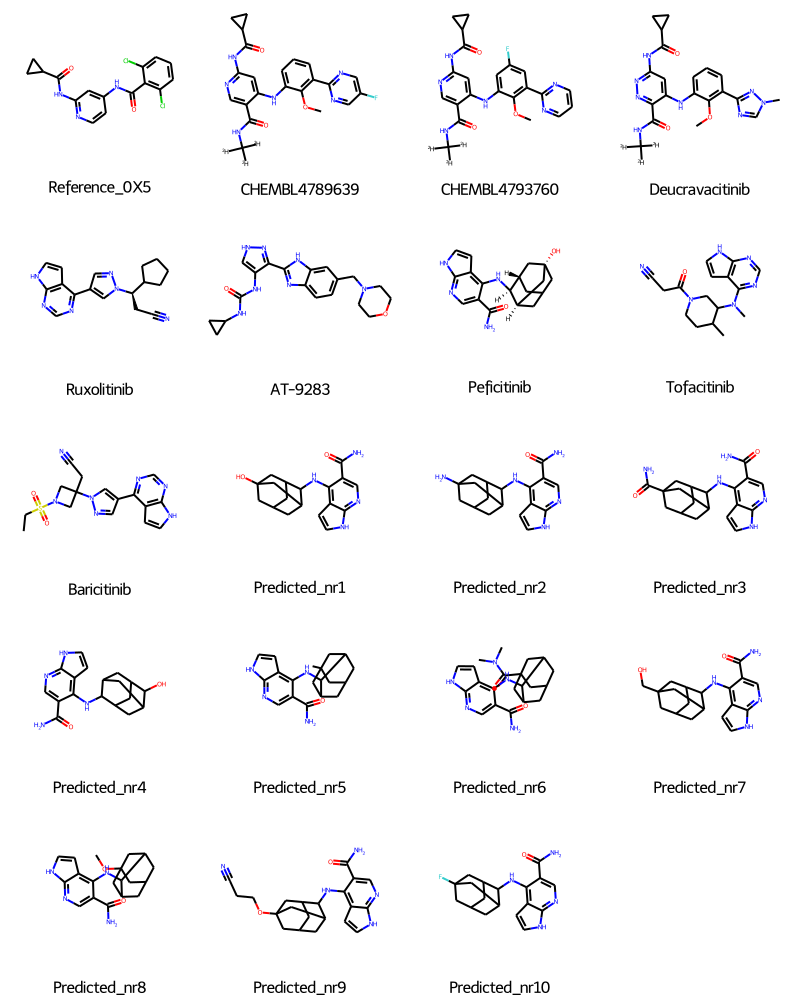

In [93]:
i = -1

IDs = []
for i in range(0,len(docking_smiles)):
    base = identifiers["ligand ID"][i]
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':docking_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

print("The first {} ligands are from the querylist. The last {} are the top {} predicted ligands in descending order.".format(len(querylist),sum(screened_data.index>(len(querylist)-1)),sum(screened_data.index>(len(querylist)-1))))
img


The above code has added hydrogens to the molecules, and saved mol2 files for each of the molecules to be used for the next docking steps.

Ask a teaching assisant to also have a look at your molecules, to check whether they look ok.

## 2. System Visualization

Next, let's have a look again at the structure:

In [94]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('Predicted_nr3.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Note that the green molecule is no longer in the binding site. This is expected, as we regenerated it from scratch and thus no longer have any coordinate information. The molecules that was co-crystalized with the protein are shown in magenta. Please doublecheck with your TA if you are not sure you have the correct ligand in magenta!

We will now try to redock the ligand in the protein binding site (re-docking), after which we can perform docking for your reference ligands.

## 3. Docking with AutoDock Vina

AutoDock Vina (Vina) is one of the docking engines in the AutoDock Suite, together with AutoDock4 (AD4), AutoDockGPU, AutoDockFR, and AutoDock-CrankPep, and arguably among the most widely used and successful docking engines. The reasons for this success are mostly due to its ease of use and its speed (up to 100x faster than AD4), when compared to the other docking engines in the suite and elsewhere, as well as being open source.

### 3.1. Protein and ligand preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand. 

We will prepare both the protein, and all of your molecules

In [95]:
def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

### 3.2. Box definition

It has been shown that using the radius of gyration, an efficient box can be generated for the docking process:
FROM: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0067-5
We will calculate the radius of gyration, as well as the center of geometry of the ligand to define the box size.

If you want to know more about this procedure, feel free to ask your TA!

In [96]:
def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center


In [97]:
# Calculate the center based on the reference ligand
RadiusOfGyration = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(RadiusOfGyration))

# Calculate center of geometry
CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Radius of Gyration = 3.607
Center Of Geometry = [-7.964, -8.699, -16.866]


### 3.4. Docking

AutoDock Vina 1.2.0, which was recently released, now allows AutoDock Vina to be executed using Python Bindings.

We will run docking on each of your ligands seperately and visually inspect the results, so be prepared to come back to this section as many times as you generated molecules!

First, we prepare the protein and ligand using the functions we defined above:

In [98]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(TARGET_PDB_ID))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [99]:
docking_smiles

0                             C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl
1       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC
2       [2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC
3        [2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC
4                                N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
5                          O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC1CC1
6                NC(=O)c1cnc2[nH]ccc2c1N[C@H]1[C@H]2CC3C[C@@H]1C[C@](O)(C3)C2
7                                   CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N
8                         CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1
3414                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)O
3601                            C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)N
3593                       C1C2CC3CC(C2)(CC1C3NC4=C5C=CNC5=NC=C4C(=O)N)C(=O)N
3420                              C1C2CC3CC(C2NC4=C5C=CNC5=NC=C4

All ligands in docking_smiles are docked, each with an exhaustiveness and n_poses ranging from 10 to x.


***This step takes a while!***

In [103]:
#Load saved data?
Load_data = True

if Load_data == True:
    print("Loading previous dataset")
    complete_data = pd.read_csv("complete_data_10_compounds_40_20.csv")
else:
    df_cols = {'ligand ID':[], 'vina_affinity': [],"prediction": [], 'prediction_type': [], 'exhaustiveness': [], 'n_poses': []}
    docked_ligands = pd.DataFrame(data=df_cols)

    for ID in df['ID']:
        print(f"\nDocking ligand ID: {ID}\n")
        for i in range(1,2,1):
            LIGAND_TO_DOCK = ID 
            m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
            a = MolToPDBQTBlock(m)
            with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
                for line in a:
                    outfile.write(line)

            v = Vina(sf_name='vina', seed = SEED)

            v.set_receptor('protein.pdbqt')

            v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

            center = {
                 'center_x' : CenterOfGeometry[0], 
                 'center_y' : CenterOfGeometry[1], 
                 'center_z' : CenterOfGeometry[2]

            }

            size = { 
                'size_x' : RadiusOfGyration * 2.9 ,
                'size_y' : RadiusOfGyration * 2.9,
                'size_z' : RadiusOfGyration * 2.9,           
                       }


            v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                                box_size=[size['size_x'], size['size_y'], size['size_z']])

            '''
            # Score the current pose
            energy = v.score()
            print('Score before minimization: %.3f (kcal/mol)' % energy[0])

            # Minimized locally the current pose
            energy_minimized = v.optimize()
            print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
            v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
            '''

            # Dock the ligand
            v.dock(exhaustiveness=20, n_poses=40)
            v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

            # Create a mol object from the docking results, write the mol to file and print the predicted affinity
            mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
            Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
            Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
            pKi = -math.log10(Ki)
            pChEMBL = pKi
            print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
            print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))
            docked_ligands.loc[len(docked_ligands)] = [LIGAND_TO_DOCK, mol.GetProp('vina_affinity'), pChEMBL, "docking", 20, 40]


    print(docked_ligands)


    docked_ligands['smiles'] = docking_smiles.to_list()
    complete_data = screened_data.append(docked_ligands).reset_index(drop=True)
    #warning this code depends on querylist, i do not know a dynamic way to code this (well i havent looked it up yet)
    chembldata=compound_df_noNaN.query('Smiles in @querylist')
    chembldata['prediction_type'] = "actual"
    chembldata['prediction'] = chembldata["pChEMBL_value"]
    chembldata['smiles'] = chembldata["Smiles"]
    chembldata = chembldata.drop(['fp', "Assay_Type", "Standard Relation", "Standard Value", "active", "Smiles", "pChEMBL_value"], axis =1)
    complete_data = complete_data.append(chembldata)
    complete_data['ligand ID'] = complete_data['smiles'].map(docked_ligands.set_index('smiles').to_dict()['ligand ID'])
    complete_data['Molecule ChEMBL ID'] = complete_data['smiles'].map(chembldata.set_index('smiles').to_dict()['Molecule ChEMBL ID'])

display(complete_data)


Loading previous dataset


,Unnamed: 0,smiles,prediction,prediction_type,ligand ID,vina_affinity,exhaustiveness,n_poses,Molecule ChEMBL ID
0,0,C1CC1C(=O)NC2=NC=CC(=C2)NC(=O)C3=C(C=CC=C3Cl)Cl,6.912572,regression,Reference_0X5,NaN,NaN,NaN,NaN
1,1,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC,7.973507,regression,CHEMBL4789639,NaN,NaN,NaN,CHEMBL4789639
2,2,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cc(F)cc(-c2ncccn2)c1OC,8.293467,regression,CHEMBL4793760,NaN,NaN,NaN,CHEMBL4793760
3,3,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC,8.726369,regression,Deucravacitinib,NaN,NaN,NaN,CHEMBL4435170
4,4,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,7.912867,regression,Ruxolitinib,NaN,NaN,NaN,CHEMBL1789941
...,...,...,...,...,...,...,...,...,...
62,1464,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1,7.280000,actual,Baricitinib,NaN,NaN,NaN,CHEMBL2105759
63,1479,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC,8.050000,actual,Deucravacitinib,NaN,NaN,NaN,CHEMBL4435170
64,1567,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC,8.000000,actual,CHEMBL4789639,NaN,NaN,NaN,CHEMBL4789639
65,1780,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncc(F)cn2)c1OC,9.720000,actual,CHEMBL4789639,NaN,NaN,NaN,CHEMBL4789639


### 3.5. 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

#### Plotting the predicted values to compare with the reference

''

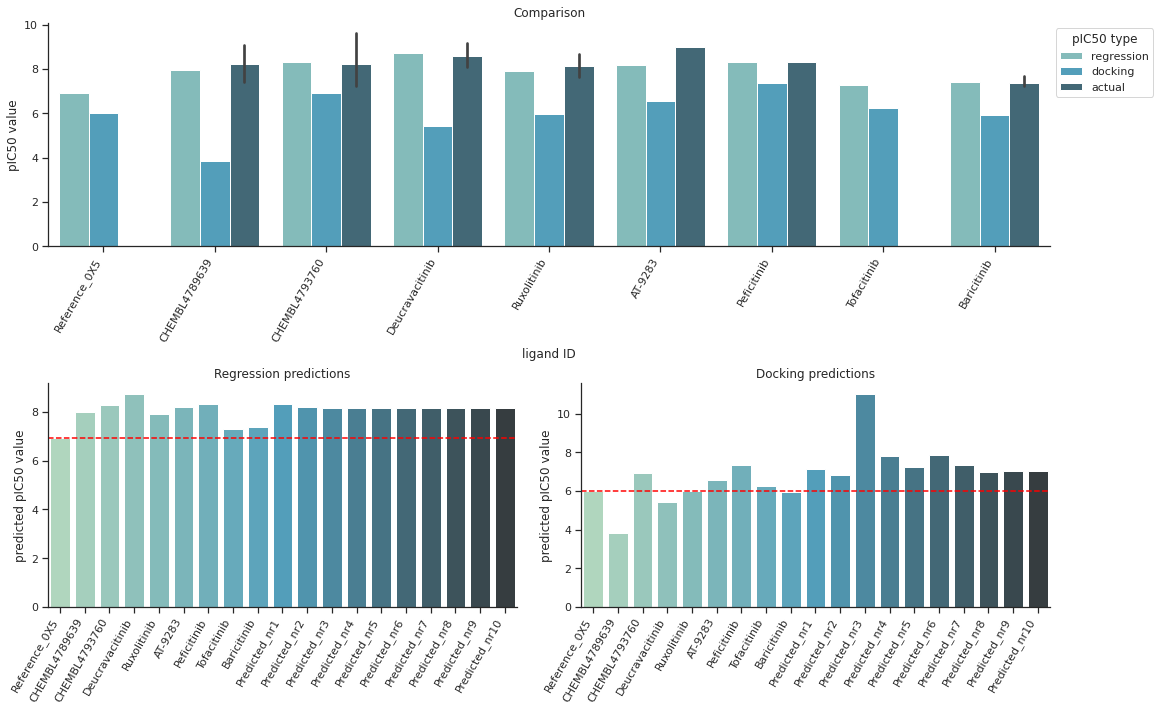

In [104]:


fig = plt.figure(constrained_layout=True)
axes = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]},)
fig.set_size_inches(16, 10)


sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

plt.sca(axes['BottomLeft'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="regression"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomLeft'].set(title = "Regression predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomLeft'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "regression"')['prediction'].values[0],
    ls='--', c='red')

plt.sca(axes['BottomRight'])
sns.barplot(
    data=complete_data[complete_data['prediction_type']=="docking"],
    x="ligand ID", y="prediction", palette="GnBu_d"
)

plt.xticks(rotation=60, ha='right')
axes['BottomRight'].set(title = "Docking predictions",
       xlabel = " ",
       ylabel = "predicted pIC50 value")
axes['BottomRight'].axhline(
    complete_data.query('`ligand ID` == "Reference_0X5" and prediction_type == "docking"')['prediction'].values[0],
    ls='--', c='red')

plt.sca(axes['Top'])
sns.barplot(
    data=complete_data.query('smiles in @querylist'),
    x="ligand ID", y="prediction", hue="prediction_type", palette="GnBu_d"
)
plt.xticks(rotation=60, ha='right')
axes['Top'].set(title = "Comparison",
       ylabel = "pIC50 value")
axes['Top'].legend(title='pIC50 type',loc=2, bbox_to_anchor=(1,1))


;


In [ ]:
complete_data.to_csv("complete_data"+time.asctime( time.localtime(time.time()))+".csv")

In [105]:
df['ID'].values

array(['Reference_0X5', 'CHEMBL4789639', 'CHEMBL4793760',
       'Deucravacitinib', 'Ruxolitinib', 'AT-9283', 'Peficitinib',
       'Tofacitinib', 'Baricitinib', 'Predicted_nr1', 'Predicted_nr2',
       'Predicted_nr3', 'Predicted_nr4', 'Predicted_nr5', 'Predicted_nr6',
       'Predicted_nr7', 'Predicted_nr8', 'Predicted_nr9',
       'Predicted_nr10'], dtype=object)

In [107]:
LIGAND_TO_SHOW = df['ID'].values[11]
print(f"Showing {LIGAND_TO_SHOW}")
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Showing Predicted_nr3
Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [110]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'Peficitinib_docked.pdb'
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = 'Predicted_nr3_docked.pdb'.format(LIGAND_TO_SHOW)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Add a nglviewer to show key interactions(?)

In [108]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
'{}_docked.pdb'.format(LIGAND_TO_SHOW)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [109]:

with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view_screened = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view_screened, selection="UNL")
view_screened

NGLWidget()

### 3.6 Analyzing the results

Does the ligand align well to your reference ligand? If not, try to rerun the docking procedure from step 4.4, do you get a different result (both in term of predicted binding affinities, as well as binding orientation)?

Now also run the docking procedure for your designed ligands, do the calculated binding affinities from docking match those from the Random Forest Classifier we used yesterday?

Think back of the lecture today, does this make sense to you? (Feel free to discuss this with a TA!)

What kind of ways can you think of to improve the results, we have covered a few in the lecture today as well.

For your presentation, you can add these improvements to your 'Future Prospects'. Unfortunately the time is limited for this course, but you are very welcome to explore (additional) methodologies in our Computational Drug Discovery group during your BOO :).